In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

import torchvision
from torchvision import transforms

import utils
%matplotlib inline

### Linear Regression Implementation from Scratch

Generate Data

torch.Size([1000, 2]) torch.Size([1000])


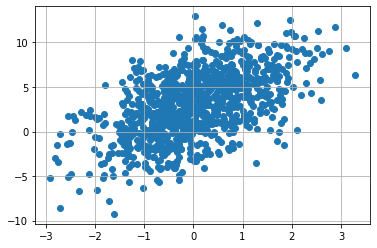

In [2]:
def generate_data(w_true, b_true, num):
    '''use true value get datum with noise'''
    X = torch.normal(0, 1, (num, len(w_true)))
    Y = X @ w_true.reshape(-1, 1) + b_true
    noise = torch.normal(0, 0.001, Y.shape)
    Y += noise
    return X, Y.reshape(-1)

w_true = torch.FloatTensor([2.0, 3.0])
b_true = torch.tensor(3.0)
num = 1000
feature, label = generate_data(w_true, b_true, num)
print(feature.shape, label.shape)
utils.plot(feature[:, 0], label, scatter=True)

Get Minibatch

In [3]:
def data_iter(feature, label, batch_size):
    num_examples = len(label)
    indices = list(range(num_examples))
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]
        )
        yield feature[batch_indices], label[batch_indices]
        
for X, y in data_iter(feature, label, 10):
    print(X, '\n', y)
    break

tensor([[-0.2480, -1.4906],
        [ 0.0523,  1.4619],
        [ 0.6797,  0.3953],
        [-0.2987, -0.1245],
        [ 0.0456,  0.7029],
        [-0.9110,  0.9341],
        [-0.1032,  0.0438],
        [-0.5089,  0.7911],
        [-0.7454,  0.2154],
        [-0.0241,  1.0344]]) 
 tensor([-1.9687,  7.4910,  5.5453,  2.0294,  5.2009,  3.9802,  2.9251,  4.3548,
         2.1544,  6.0557])


Linear Model

In [4]:
def LinearReg(X, w, b):
    return X @ w.reshape(-1, 1) + b

w = torch.normal(0, 1, (2,))
b = torch.normal(0, 1, (1,))
print(w, b)
LinearReg(torch.arange(6.0).reshape(-1, 2), w, b)

tensor([0.4496, 1.1560]) tensor([-2.7453])


tensor([[-1.5894],
        [ 1.6217],
        [ 4.8327]])

Loss Function: MSE

In [5]:
def MSE(y_hat, y):
    return (0.5 * (y_hat - y.reshape(y_hat.shape))**2).mean()

y_hat = torch.arange(5)
y = torch.zeros(5)
MSE(y_hat, y)

tensor(3.)

Optimization: SGD

In [6]:
def SGD(params, lr):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

Train

In [7]:
w = torch.normal(0, 1, (2,), requires_grad = True)
b = torch.normal(0, 1, (1,), requires_grad = True)

epochs = 10
batch_size = 100
lr = 0.1

for epoch in range(epochs):
    for X, y in data_iter(feature, label, batch_size):
        y_hat = LinearReg(X, w, b)
        loss = MSE(y_hat, y)
        loss.backward()
        SGD([w, b], lr)
    with torch.no_grad():
        train_l = MSE(LinearReg(feature, w, b), label)
        print(f'epoch: {epoch}, loss: {float(train_l)}')

epoch: 0, loss: 1.2666330337524414
epoch: 1, loss: 0.15104657411575317
epoch: 2, loss: 0.01804666966199875
epoch: 3, loss: 0.0021540909074246883
epoch: 4, loss: 0.00025756401009857655
epoch: 5, loss: 3.125908915535547e-05
epoch: 6, loss: 4.210821771266637e-06
epoch: 7, loss: 9.406645631315769e-07
epoch: 8, loss: 5.488460033120646e-07
epoch: 9, loss: 5.036114316681051e-07


In [8]:
w, b

(tensor([2.0000, 2.9999], requires_grad=True),
 tensor([2.9999], requires_grad=True))

### Concise Implementation of Linear Regression

Get Data Iter

In [9]:
def load_array(arrays, batch_size):
    dataset = data.TensorDataset(*arrays)
    return data.DataLoader(dataset, batch_size)

Data_iter = load_array((feature, label),batch_size)

Model, Loss and Optimization

In [10]:
LinModel = nn.Sequential(
    nn.Linear(2, 1)
)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(LinModel.parameters(), lr)

Train

In [11]:
for epoch in range(epochs):
    for X, y in Data_iter:
        loss = loss_fn(LinModel(X).reshape(y.shape), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        train_l = loss_fn(LinModel(feature).reshape(-1), label)
        print(f'epoch: {epoch}, loss: {float(train_l)}')

epoch: 0, loss: 0.20501799881458282
epoch: 1, loss: 0.002330343471840024
epoch: 2, loss: 2.7819338356493972e-05
epoch: 3, loss: 1.33702928906132e-06
epoch: 4, loss: 1.004941736937326e-06
epoch: 5, loss: 9.979200967791257e-07
epoch: 6, loss: 9.975153716368368e-07
epoch: 7, loss: 9.97485471998516e-07
epoch: 8, loss: 9.97485471998516e-07
epoch: 9, loss: 9.97485471998516e-07


In [12]:
LinModel[0].weight.data, LinModel[0].bias.data

(tensor([[2.0000, 3.0000]]), tensor([2.9999]))

### Fashion-MNIST

Download Fashion MNIST

In [13]:
# Transform PIL to float32 using ToTensor
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root = './data',
    train = True,
    transform = trans,
    download = True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root = './data',
    train = False,
    transform = trans,
    download = True
)

Using downloaded and verified file: ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw

Using downloaded and verified file: ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



4422656it [00:02, 1575562.62it/s]                             


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



6144it [00:00, 29999771.57it/s]         

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [14]:
len(mnist_train), len(mnist_test)

(60000, 10000)

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

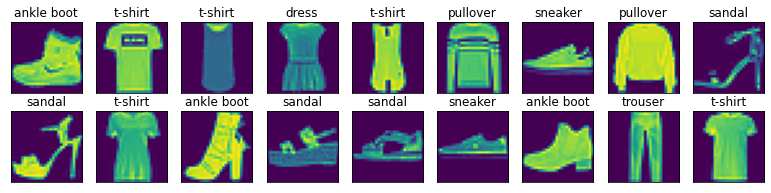

In [15]:
def get_fashion_mnist_labels(labels):
    '''get labels'''
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

Load Data

In [16]:
batch_size = 256

train_iter = data.DataLoader(mnist_train, batch_size, shuffle = True)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle = True)

Put these in a function

In [17]:
def load_fashion_mnist(batch_size, resize = None):
    '''Download Fashion MNIST, and load it to memory'''
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root = './data',
        train = True,
        transform = trans,
        download = True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root = './data',
        train = False,
        transform = trans,
        download = True
    )
    return (data.DataLoader(mnist_train, batch_size, shuffle=True),
            data.DataLoader(mnist_test, batch_size, shuffle=False))
    
train_iter, test_iter = load_fashion_mnist(32, resize = 64)
for X, y in train_iter:
    print(X.shape, y.shape, X.dtype, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.Size([32]) torch.float32 torch.int64


### Softmax Regression Implementation from Scratch

Model

In [18]:
def softmax(o):
    return torch.exp(o)/torch.exp(o).sum(dim = 1).reshape(-1, 1)

o = torch.arange(12).reshape(3, 4)
softmax(o).sum(dim = 1)

tensor([1., 1., 1.])

In [19]:
def SoftmaxReg(X, W, b):
    return softmax(X @ W + b)

W = torch.normal(0, 1, (4, 3))
b = torch.normal(0, 1, (1, 3))

X = torch.normal(0, 1, (6, 4))
SoftmaxReg(X, W, b)

tensor([[0.6244, 0.0369, 0.3387],
        [0.1818, 0.0572, 0.7610],
        [0.7298, 0.1990, 0.0711],
        [0.1682, 0.4625, 0.3693],
        [0.2351, 0.1530, 0.6119],
        [0.5694, 0.4239, 0.0067]])

Loss

In [20]:
def CrossEntropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)),y]).mean()

y = torch.tensor([0, 1, 2])
y_hat = torch.tensor([[0.8, 0.1, 0.1], 
                      [0.1, 0.8, 0.1], 
                      [0.1, 0.1, 0.8]])
CrossEntropy(y_hat, y)

tensor(0.2231)

Train

In [21]:
epochs = 10
lr = 0.1
batch_size = 64
resize = 32

feature_num = resize ** 2
label_num = 10

# Load Dataset
train_iter, test_iter = utils.load_fashion_mnist(batch_size, resize)

# Initialize parameters
W = torch.normal(0, 1, (feature_num, label_num), requires_grad = True)
b = torch.normal(0, 1, (label_num,), requires_grad = True)

# metric
train_metric = utils.Accumulator(3)
test_metric = utils.Accumulator(3)

for epoch in range(epochs):
    train_metric.reset()
    test_metric.reset()
    for X, y in train_iter:
        X = X.reshape(X.shape[0], feature_num)
        y_hat = SoftmaxReg(X, W, b)
        loss = CrossEntropy(y_hat, y)
        loss.backward()
        SGD([W, b], lr)
        train_metric.add(float(loss) * batch_size, utils.accuracy(y_hat, y), y.numel())
    print(f'epoch: {epoch}, train loss: {train_metric[0]/train_metric[2]:.3f}, train accuracy: {train_metric[1]/train_metric[2]:.3f}')
    with torch.no_grad():
        for X, y in test_iter:
            X = X.reshape(X.shape[0], feature_num)
            y_hat = SoftmaxReg(X, W, b)
            loss = CrossEntropy(y_hat, y)
            test_metric.add(float(loss) * batch_size, utils.accuracy(y_hat, y), y.numel())
    print(f'epoch: {epoch}, test loss: {test_metric[0]/test_metric[2]:.3f}, test accuracy: {test_metric[1]/test_metric[2]:.3f}')

epoch: 0, train loss: 2.095, train accuracy: 0.619
epoch: 0, test loss: 1.353, test accuracy: 0.689
epoch: 1, train loss: 1.115, train accuracy: 0.741
epoch: 1, test loss: 1.050, test accuracy: 0.738
epoch: 2, train loss: 0.945, train accuracy: 0.768
epoch: 2, test loss: 1.063, test accuracy: 0.745
epoch: 3, train loss: 0.852, train accuracy: 0.781
epoch: 3, test loss: 0.863, test accuracy: 0.771
epoch: 4, train loss: 0.791, train accuracy: 0.790
epoch: 4, test loss: 0.884, test accuracy: 0.759
epoch: 5, train loss: 0.743, train accuracy: 0.799
epoch: 5, test loss: 0.790, test accuracy: 0.793
epoch: 6, train loss: 0.711, train accuracy: 0.802
epoch: 6, test loss: 0.748, test accuracy: 0.799
epoch: 7, train loss: 0.684, train accuracy: 0.807
epoch: 7, test loss: 0.714, test accuracy: 0.799
epoch: 8, train loss: 0.661, train accuracy: 0.810
epoch: 8, test loss: 0.718, test accuracy: 0.794
epoch: 9, train loss: 0.642, train accuracy: 0.814
epoch: 9, test loss: 0.719, test accuracy: 0.800


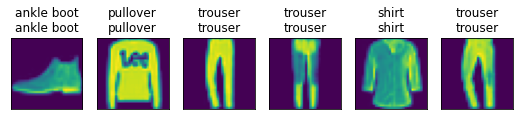

In [22]:
def predict(W, b, test_iter, n = 6):
    X, y = next(iter(test_iter))
    trues = utils.get_fashion_mnist_labels(y)
    
    preds = utils.get_fashion_mnist_labels(SoftmaxReg(X.reshape(X.shape[0], -1), W, b).argmax(axis = 1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    utils.show_images(X[0:n].reshape((n, 32, 32)), 1, n, titles=titles[0:n])

predict(W, b, test_iter)


### Concise Implementation of Softmax Regression

In [23]:
class SoftmaxRegression(nn.Module):
    def __init__(self, num_in, num_out):
        super().__init__()
        self.l = nn.Linear(num_in, num_out)
        
    def forward(self, X):
        X = X.reshape(X.shape[0], -1)
        return F.softmax(self.l(X), dim = 1)

def predict(model, test_iter, n = 6):
    X, y = next(iter(test_iter))
    trues = utils.get_fashion_mnist_labels(y)
    
    preds = utils.get_fashion_mnist_labels(model(X).argmax(axis = 1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    utils.show_images(X[0:n].reshape((n, 32, 32)), 1, n, titles=titles[0:n])

epochs = 10
lr = 0.1
batch_size = 64
resize = 32

feature_num = resize ** 2
label_num = 10

train_iter, test_iter = utils.load_fashion_mnist(batch_size, resize)
model = SoftmaxRegression(feature_num, label_num)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

metric = utils.Accumulator(3)
for epoch in range(epochs):
    metric.reset()
    for X, y in train_iter:
        optimizer.zero_grad()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        metric.add(float(loss.sum()), utils.accuracy(y_hat, y), y.numel())
    print(f'epoch: {epoch}, loss: {metric[0] / metric[2]:.3f}, train accuracy: {metric[1] / metric[2]:.3f}')


epoch: 0, loss: 0.029, train accuracy: 0.645
epoch: 1, loss: 0.028, train accuracy: 0.714
epoch: 2, loss: 0.027, train accuracy: 0.723
epoch: 3, loss: 0.027, train accuracy: 0.728
epoch: 4, loss: 0.027, train accuracy: 0.731
epoch: 5, loss: 0.027, train accuracy: 0.734
epoch: 6, loss: 0.027, train accuracy: 0.736
epoch: 7, loss: 0.027, train accuracy: 0.737
epoch: 8, loss: 0.027, train accuracy: 0.738
epoch: 9, loss: 0.027, train accuracy: 0.739


test accuracy: 0.736


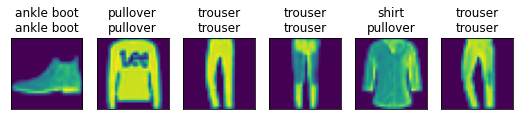

In [24]:
print('test accuracy: {:.3f}'.format(utils.evaluate_accuracy(model, test_iter)))
predict(model, test_iter) 